In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

2023-12-15 13:44:02.142974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 13:44:02.323121: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-15 13:44:03.184412: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.3/lib64
2023-12-15 13:44:03.184511: W te

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
with tf.compat.v1.Session(config=config) as sess:

    # 메모리 40% 할당
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.9
    sess = tf.compat.v1.Session(config=config)

2023-12-15 13:44:04.188260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 13:44:06.136331: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78900 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0
2023-12-15 13:44:06.159314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78900 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [3]:
import pickle

with open('./Pretraning_data/ZINC_10M_data','rb') as file:
    train = pickle.load(file)

In [4]:
train[1]

'O=C(NC(=O)c1cccc(F)c1)O[C@H]1CCS(=O)(=O)C1'

In [13]:
from SmilesPE import tokenizer

tokenizer.atomwise_tokenizer(train[1:5])

TypeError: expected string or bytes-like object

In [14]:
from rdkit import Chem
from tqdm import tqdm
def Chem_generator(smiles):
    res_list = []
    for i in tqdm(smiles):
        mol = Chem.MolFromSmiles(i)
        temp = []
        index = 0
        while(len(set(temp))!=4 and index != 100):
            index+=1
            temp.append(Chem.MolToSmiles(mol,doRandom=True))
        res_list+=list(set(temp))
    return res_list

In [15]:
train_1 = Chem_generator(train)

 29%|██▊       | 3578369/12525050 [23:42<1:05:59, 2259.71it/s]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf
def scaled_dot_product(Q,K,V):
        mat_QK = tf.matmul(Q,K,transpose_b=True)
        depth = tf.cast(tf.shape(K)[-1], tf.float32)
        logits = mat_QK / tf.math.sqrt(depth)
    

        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, V)

        return output, attention_weights

class self_multihead(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,name='multiheadatten'):
        super(self_multihead,self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model%num_heads == 0

        self.depth = d_model//self.num_heads
        self.Q = Dense(units=d_model)
        self.K = Dense(units=d_model)
        self.V = Dense(units=d_model)

        self.linear = Dense(units = d_model)

    def split(self,inputs,batch_size):
        inputs = tf.reshape(inputs, [batch_size,-1,self.num_heads,self.depth])
        return tf.transpose(inputs,perm=[0,2,1,3])

    def call(self,inputs):
        Q,K,V = inputs,inputs,inputs
        batch_size = tf.shape(Q)[0]
        
        # Denselayer
        Q = self.Q(Q)
        K = self.K(K)
        V = self.V(V)
        #Splithead 

        Q = self.split(Q,batch_size)
        K = self.split(K,batch_size)
        V = self.split(V,batch_size)
        #Scaled dot product
        scaled_att,_ = scaled_dot_product(Q,K,V)
        #(batchsize,sentence_size,num_heads,word_size/num_heads)
        scaled_attention = tf.transpose(scaled_att, perm=[0,2,1,3])
        #Concate
        concat_attention = tf.reshape(scaled_attention, [batch_size, -1, self.d_model])
        #Linear Dense
        outputs = self.linear(concat_attention)

        return outputs



def scheduler(epochs,lr):
    lr = 0.5*(1+np.cos(np.pi * epochs / 100))
    if epochs <= 5:
        lr *= epochs * 1.0 / 30
    return lr

class transformer(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,ff_dim,name):
        super(transformer,self).__init__(name=name)
        self.attn = self_multihead(d_model,num_heads)
        self.ff = Sequential([Dense(ff_dim,activation='relu'),Dense(d_model)])
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
    
    def call(self, inputs):
        attn_out = self.attn(inputs)
        out1 = self.norm1(inputs + attn_out)
        ffn_output = self.ff(out1)
        return self.norm2(out1 + ffn_output)

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,mask_zero=True)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim,mask_zero = True)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=1, limit=maxlen+1, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        mask = self.token_emb.compute_mask(x)
        return x + positions
    

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        l2_reg = tf.keras.regularizers.l2(0.01)
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,kernel_regularizer=l2_reg,dropout=0.1)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
def replace_zeros_with_ones(input_tensor):
    # input_tensor에서 0인 값을 1로 바꾸는 연산
    modified_tensor = tf.where(tf.equal(input_tensor, 0), 1, input_tensor)
    return modified_tensor


def calculate_means(input_list, index_ranges):
    # TensorFlow 상수로 입력 리스트를 변환
    input_tensor = tf.constant(input_list)
    
    # 각각의 인덱스 범위를 나누어 평균 계산
    averages = [tf.reduce_mean(input_tensor[start:end]) for start, end in index_ranges]
    
    return averages


class Mask(tf.keras.layers.Layer):
    def __init__(self):
        super(Mask, self).__init__()
    def call(self, inputs,mask):
        prob = np.random.rand(1)[0]
        if prob<0.8:
            return tf.multiply(inputs,((mask-1)*(-1)))
        elif prob>=0.8:
            random_value = tf.random.uniform(shape=[inputs.shape[0]], minval=0, maxval=inputs.shape[1], dtype=tf.int32)
            random_value = mask*random_value[:,tf.newaxis]
            random_value = replace_zeros_with_ones(random_value)
            return tf.multiply(inputs,(random_value))
        else:
            return inputs




class BERT(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim):
        super(BERT, self).__init__()
        #self.encoder = tf.keras.Sequential([TransformerBlock(emb_dim,num_heads,ff_dim) for i in range(8)])
        self.encoder = TransformerBlock(emb_dim,num_heads,ff_dim)
        self.embedding = TokenAndPositionEmbedding(200,3500,256)
        self.dense = layers.Dense(250,activation = 'gelu')
        self.classify = layers.Dense(len(molecule_dictionary),activation = 'softmax')
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
            
        hidden = self.embedding(inputs)
        
        for i in range(8):
            hidden = self.encoder(hidden)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            output = tf.boolean_mask(output,boolean_mask)
            return output
        else:
            return hidden

In [ ]:
A = BERT(256,6,1024)

2023-12-11 14:23:07.702169: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78900 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


NameError: name 'molecule_dictionary' is not defined

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = float(step+1)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(1e-4) * tf.math.minimum(arg1, arg2)

temp_learning_rate_schedule = CustomSchedule(256,10000)
callback = tf.keras.callbacks.LearningRateScheduler(temp_learning_rate_schedule, verbose=0)

In [ ]:
from tdc.single_pred import Tox
from Module import RDK as rk
import atomInSmiles
from Module import Fine_tune

In [ ]:
from multiprocessing import Pool
from tqdm import tqdm
from multiprocessing import Process, Value, Array
from multiprocessing import Process,Manager,current_process
from Module import RDK as rk
import atomInSmiles 

train_set = []

def process_data(item):
    train_set.append(atomInSmiles.encode(item,True).split(' '))
    
    
if __name__ == '__main__':
    manager = Manager()
    train_set = manager.list(train_set)
    pool = Pool(60)
    pool.map(process_data, train_1)
    pool.close()
    pool.join()



In [ ]:
from multiprocessing import Pool
from tqdm import tqdm
from multiprocessing import Process, Value, Array
from multiprocessing import Process,Manager,current_process
from Module import RDK as rk
import atomInSmiles 
from SmilesPE import tokenizer

train_set = []
def process_data(item):
    train_set.append(tokenizer.atomwise_tokenizer([item])[0])


if __name__ == '__main__':
    manager = Manager()
    train_set = manager.list(train_set)
    pool = Pool(60)
    pool.map(process_data, train)
    pool.close()
    pool.join()


In [ ]:
temp = []

for i in tqdm(train_set):
    temp.append(i)
    
    
train_set = temp

100%|██████████| 50100189/50100189 [41:01<00:00, 20353.78it/s] 


Text(0, 0.5, 'counts')

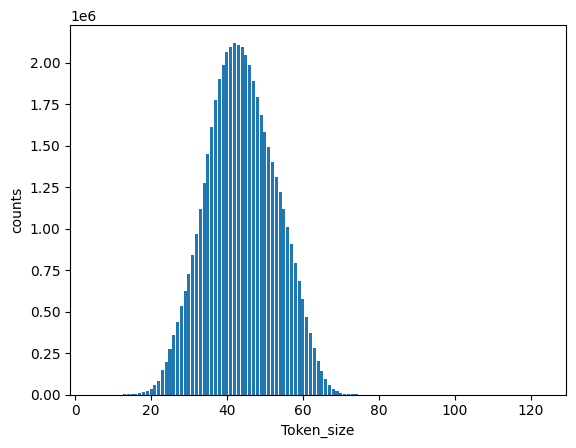

In [ ]:
import matplotlib.pyplot as plt
length_list = {}


for index,i in enumerate(train_set):
    try:
        length_list[len(i)]=length_list[len(i)]+1
    except:
        length_list[len(i)] = 1
    
plt.bar(length_list.keys(),length_list.values())
plt.xlabel(xlabel='Token_size')
plt.ylabel('counts')    

In [ ]:
temp_dict = {}
for i in train_set:
    for j in i:
        try:
            temp_dict[j] = temp_dict[j] + 1
        except:
            temp_dict[j] = 1
remove_dict = {}
for i in temp_dict.keys():
    if temp_dict[i]<50:
        print(i,temp_dict[i])
        remove_dict[i] = 1

remove_list = []
for index,i in enumerate(train_set):
    for j in i:
        try:
            remove_dict[j]
            remove_list.append(index)
            break
        except:
            continue

remove_list.sort(reverse=True)

[C;!R;CFN] 20
[CH2;!R;FO] 24
[C;!R;BrCClCl] 36
[P;R;CNN] 16
[Si;!R;CSiSiSi] 12
[C;!R;BrCF] 32
[c;R;NSSi] 24
[CH;!R;SSS] 36
[NH;R;NP] 16
[N;!R;OO] 4
[C;R;ClClSS] 24
[[N-];!R;ClS] 24
[S;R;CCC] 24
[N;!R;CSiSi] 16
[C;!R;BrBrCP] 8
[N;R;NOO] 4
[C;!R;BrBrBrS] 12
[O;!R;NN] 20
[n;R;BrCN] 4
[C;R;BrCCS] 20
[C;R;BrSSS] 4
[CH2;!R;FN] 16
[CH;!R;ClNN] 4
[N;!R;CCCl] 44
[n;R;COO] 8
[C;R;CFO] 12
[N;!R;OS] 48
[[N+];!R;CCN] 40
[c;R;CPS] 16
[c;R;CFO] 4
[n;R;BrCC] 16
[NH;!R;P] 12
[C;R;CFSS] 8
[N;R;CSiSi] 28
[Si;R;CNN] 32
[[NH+];R;CSiSi] 16
[n;R;COS] 48
[[NH2+];!R;S] 32
[CH;!R;CFP] 16
[Si;!R;CNNN] 12
[N;!R;CCSi] 28
[N;!R;PPP] 8
[C;R;SSSS] 12
[N;!R;CClCl] 12
[SH;R;CC] 48
[C;R;BrCSS] 20
[C;R;CClO] 4
[C;!R;OOP] 20
[C;!R;CFO] 44
[[PH+];R;NNN] 8
[[NH+];R;CCN] 16
[C;!R;CClClP] 20
[S;!R;CCOS] 16
[[N+];R;BrCCC] 12
[[N+];!R;PP] 12
[C;!R;CFPP] 16
[C;R;CClClS] 28
[[NH2+];!R;P] 4
[[NH+];!R;PP] 8
[O;!R;CCl] 16
[Cl;!R;O] 28
[[PH+];!R;NNN] 48
[P;!R;NNO] 8
[[NH2+];!R;CP] 8
[[PH+];!R;NNO] 28
[[N-];R;CP] 36
[C;!R;OOSi] 20
[CH

In [ ]:
for i in remove_list:
    train_set.pop(i)
print(len(train_set))

50094160


In [ ]:
import pickle
with open('./Pretraning_data/Random_ZINC_50M_SMILE_tokken.pkl','wb') as file:
    pickle.dump(train_set,file)

In [ ]:
import pickle
with open('./Pretraning_data/Random_ZINC_50M_SMILE_tokken.pkl','rb') as file:
    train_set = pickle.load(file)

In [ ]:
import pickle
molecule_dictionary = {'<start>':1,'<end>':2,'<unknown1>':3,'<unknown2>':4,'<unknown3>':5,'<unknow4>':6,'<unknown5>':7}

for molecule in train_set:
    for atom in molecule:
        try:
            molecule_dictionary[atom]
        except:
            molecule_dictionary[atom] = len(molecule_dictionary)+1
with open('./BERT/SMILE/1M_random_ZINC_word2index.pkl','wb') as file:
    pickle.dump(molecule_dictionary,file)
len(molecule_dictionary)

732

In [ ]:
from tqdm import tqdm
import numpy as np 

def word_to_index(train_set,dict):
    result = []
    for molecule in tqdm(train_set):
        temp_list = []
        temp_list.append(1)
        for atom in molecule:
            temp_list.append(dict[atom])
        while len(temp_list)!=200:
            temp_list.append(0)
        result.append(temp_list)
    return result
embedding_word = word_to_index(train_set,molecule_dictionary)   
embedding_word = np.array(embedding_word)

  0%|          | 0/50094160 [00:00<?, ?it/s]

100%|██████████| 50094160/50094160 [16:49<00:00, 49615.02it/s] 


In [ ]:
from tdc.single_pred import Tox
from Module import RDK
import atomInSmiles

def word_to_index(train_set,dict):
    result = []
    for molecule in tqdm(train_set):
        temp_list = []
        temp_list.append(1)
        for atom in molecule:
            temp_list.append(dict[atom])
        while len(temp_list)!=200:
            temp_list.append(0)
        result.append(temp_list)
    return result
train_val,tox_info = Tox(name = 'AMES').get_data(format = 'DeepPurpose')
train_set_val = []

train_val = Chem_generator(train_val[:5000])


for i in train_val:
    train_set_val.append(atomInSmiles.encode(i,True).split(' '))
val_remove_list = []
for index,i in enumerate(train_set_val):
    for j in i:
        try:
            molecule_dictionary[j]
        except:
            val_remove_list.append(index)
            break
val_remove_list.sort(reverse=True)

for i in val_remove_list:
    train_set_val.pop(i)

embedding_word_val = word_to_index(train_set_val,molecule_dictionary)   
embedding_word_val = np.array(embedding_word_val)

Found local copy...
Loading...
Done!
100%|██████████| 19122/19122 [00:00<00:00, 71215.89it/s]


In [ ]:
import random
max = 16
mask_input_val = []
for j in tqdm(train_set_val):
        value = []
        number = int(len(j)*0.15)
        if number>max:
                max = number
        if number == 0:
                number = 1
        value += random.sample(range(1,len(j)),number)
        mask_input_val.append(value)
        
        
for j in mask_input_val:
        while(len(j)<max):
                j.append(-1)


random_value_val = embedding_word_val.copy()        
for _,index in enumerate(mask_input_val):
        for j in index:
                if j != -1:
                        prob = np.random.rand(1)[0]
                        if prob < 0.8:
                                random_value_val[_][j] = 0
                        elif prob > 0.9:
                                temp1 = random.sample(range(0,301),1)[0]
                                random_value_val[_][j] = temp1
                                
output_val = tf.multiply(tf.reduce_sum(tf.one_hot(mask_input_val,200),axis=1),embedding_word_val)

100%|██████████| 19122/19122 [00:00<00:00, 264918.29it/s]


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import *
early_stopping_cb = EarlyStopping(patience=6, monitor='loss',restore_best_weights=True)

In [ ]:
def custom_loss(y_true, y_pred):
    output = tf.one_hot(tf.cast(tf.boolean_mask(y_true,tf.cast(y_true,bool)),tf.int32),len(molecule_dictionary))
    loss = tf.keras.losses.CategoricalCrossentropy()(output,y_pred)
    return loss

In [ ]:
def Custom_metric(y_true,y_pred):
    predictions = tf.argmax(y_pred,axis=1)
    true = tf.boolean_mask(y_true,tf.cast(y_true,bool))
    return  tf.metrics.Accuracy()(predictions,true)
def Mask_acc(y_true, y_pred):
    score = tf.py_function(func=Custom_metric, inp=[y_true, y_pred], Tout=tf.float32,  name='Custom_acc') 
    return score

In [ ]:
class BERT(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim):
        super(BERT, self).__init__()
        self.transformer = TransformerBlock(emb_dim,num_heads,ff_dim)
        self.normalize = tf.keras.layers.LayerNormalization(epsilon=1e-8)
        
        self.embedding = TokenAndPositionEmbedding(200,3500,256)
        self.dense = layers.Dense(250,activation = 'gelu')
        self.classify = layers.Dense(len(molecule_dictionary),activation = 'softmax')
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
        
        hidden = self.embedding(inputs)
        hidden = self.normalize(hidden)
        for i in range(8):
            hidden = self.transformer(hidden)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = tf.boolean_mask(output,boolean_mask)
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            return output
        else:
            return hidden

In [ ]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,mask_zero=True)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim,mask_zero = True)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=1, limit=maxlen+1, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [59]:
class BERT(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim):
        super(BERT, self).__init__()
        self.encoder = tf.keras.Sequential([TransformerBlock(emb_dim,num_heads,ff_dim) for i in range(8)])
        #self.encoder = TransformerBlock(emb_dim,num_heads,ff_dim)
        #self.normalize = tf.keras.layers.LayerNormalization(epsilon=1e-8)
        
        self.embedding = TokenAndPositionEmbedding(200,3500,256)
        self.dense = layers.Dense(250,activation = 'gelu')
        self.classify = layers.Dense(len(molecule_dictionary),activation = 'softmax')
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
            
        hidden = self.embedding(inputs)
        hidden = self.encoder(hidden)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            output = tf.boolean_mask(output,boolean_mask)
            return output
        else:
            return hidden

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import Embedding
inputs = Input(shape = (200,),dtype=tf.int32)
mask = Input(shape = (16), dtype=tf.int32)
outputs = BERT(256,6,1024)(inputs,mask,pretrain=True)

model = Model(inputs = [inputs,mask], outputs = [outputs])
model.summary()
optmizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optmizer,loss = custom_loss,metrics = Mask_acc)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 16)]         0           []                               
                                                                                                  
 bert_10 (BERT)                 (None, 732)          18029742    ['input_19[0][0]',               
                                                                  'input_20[0][0]']               
                                                                                                  
Total params: 18,029,742
Trainable params: 18,029,742
Non-trainable params: 0
______________

In [56]:
temp_weights = model.get_weights()

In [61]:
all_weights = temp_weights[:16]*8 + temp_weights[16:]

In [62]:
model.set_weights(all_weights)

In [ ]:
optmizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optmizer,loss = custom_loss,metrics = Mask_acc)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.batch_count
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    self.batch_count += 1
    step = float(step+1)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(1000.) * tf.math.minimum(arg1, arg2)

In [ ]:
class CustomLearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps=4000):
        super(CustomLearningRateScheduler, self).__init__()
        self.warmup_steps = warmup_steps
        self.step = tf.Variable(0, trainable=False)

    def __call__(self, step):
        self.step.assign_add(1)  # 각 배치가 지나갈 때마다 step 증가
        lr = tf.cond(
            self.step <= self.warmup_steps,
            lambda: (1e-4 - 1e-9) / self.warmup_steps * tf.cast(self.step, tf.float32) + 1e-9,
            lambda: 0.5 * (1e-4 + 1e-9) * (self.warmup_steps ** 0.5) / (tf.cast(self.step, tf.float32) ** 0.5)
        )
        return lr

In [ ]:
lr = CustomLearningRateScheduler()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer= optimizer, loss = custom_loss, metrics= Mask_acc)

In [55]:
model.load_weights('./BERT/SMILE/Random_ZINC_L_model_weights.h5')

In [67]:
model.compile(optimizer= optimizer, loss = custom_loss, metrics= Mask_acc)

In [68]:
len(embedding_word)

50094160

In [69]:

import random
size = 300000
for k in range(1,11):
        for i in range(0,int(len(embedding_word)/size)):
                if k == 1:
                        i = i
                if i == int(len(embedding_word)/size):
                        break
                if i <80:
                        lr = (1e-4-1e-6)*(i)/80 + 1e-6
                else:
                        lr = 1e-4*np.sqrt(80)/np.sqrt(i)
                optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
                model.compile(optimizer= optimizer, loss = custom_loss, metrics= Mask_acc)
                max = 16
                mask_input = []
                for j in tqdm(train_set[size*i:size*(i+1)]):
                        value = []
                        number = int(len(j)*0.15)
                        if number>max:
                                number = max
                        if number == 0:
                                number = 1
                        value += random.sample(range(1,len(j)),number)
                        mask_input.append(value)
                        
                        
                for j in mask_input:
                        while(len(j)<max):
                                j.append(-1)
                
                
                
                
                
                
                inputs1 = embedding_word[size*i:size*(i+1)]
                inputs2 = mask_input
                output = tf.multiply(tf.reduce_sum(tf.one_hot(inputs2,200),axis=1),inputs1)

                
                random_value = inputs1.copy()        
                for _,index in enumerate(inputs2):
                        for j in index:
                                if j != -1:
                                        prob = np.random.rand(1)[0]
                                        if prob < 0.8:
                                                random_value[_][j] = 0
                                        elif prob > 0.9:
                                                temp1 = random.sample(range(0,301),1)[0]
                                                random_value[_][j] = temp1
                                                
                
                
                print(f'This is {i} number step')
                with tf.device('/device:GPU:0'):
                        if i % 20 == 0:
                                model.fit([np.array(random_value),np.array(inputs2)],np.array(output,dtype = int),epochs=1,batch_size=256,callbacks = [early_stopping_cb],validation_data=([np.array(random_value_val),np.array(mask_input_val)],np.array(output_val)))
                        else:
                                model.fit([np.array(random_value),np.array(inputs2)],np.array(output,dtype = int),epochs=1,batch_size=256,callbacks = [early_stopping_cb])
                        print(model.optimizer.lr)
                        model.save_weights('./BERT/SMILE/Random_ZINC_L_model_weights.h5')

100%|██████████| 300000/300000 [00:01<00:00, 184415.67it/s]


This is 0 number step
1172/1172 [==============================] - 403s 330ms/step - loss: 2.2020 - Mask_acc: 0.5478 - val_loss: 2.0894 - val_Mask_acc: 0.6043
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 183493.22it/s]


This is 1 number step
1172/1172 [==============================] - 392s 320ms/step - loss: 1.8525 - Mask_acc: 0.5957
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 191181.64it/s]


This is 2 number step
1172/1172 [==============================] - 393s 321ms/step - loss: 1.6956 - Mask_acc: 0.6254
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 184046.11it/s]


This is 3 number step
1172/1172 [==============================] - 392s 320ms/step - loss: 1.5877 - Mask_acc: 0.6465
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 175266.80it/s]


This is 4 number step
1172/1172 [==============================] - 390s 318ms/step - loss: 1.5047 - Mask_acc: 0.6623
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 172684.74it/s]


This is 5 number step
1172/1172 [==============================] - 390s 319ms/step - loss: 1.4285 - Mask_acc: 0.6789
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 176320.31it/s]


This is 6 number step
1172/1172 [==============================] - 394s 322ms/step - loss: 1.3596 - Mask_acc: 0.6943
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 176713.24it/s]


This is 7 number step
1172/1172 [==============================] - 392s 320ms/step - loss: 1.3114 - Mask_acc: 0.7028
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 180849.20it/s]


This is 8 number step
1172/1172 [==============================] - 393s 321ms/step - loss: 1.2759 - Mask_acc: 0.7120
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 179745.51it/s]


This is 9 number step
1172/1172 [==============================] - 394s 322ms/step - loss: 1.2278 - Mask_acc: 0.7218
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 182191.74it/s]


This is 10 number step
1172/1172 [==============================] - 392s 321ms/step - loss: 1.1854 - Mask_acc: 0.7321
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 181548.60it/s]


This is 11 number step
1172/1172 [==============================] - 390s 318ms/step - loss: 1.1507 - Mask_acc: 0.7379
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 182507.53it/s]


This is 12 number step
1172/1172 [==============================] - 391s 319ms/step - loss: 1.1146 - Mask_acc: 0.7459
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 177599.65it/s]


This is 13 number step
1172/1172 [==============================] - 392s 321ms/step - loss: 1.0822 - Mask_acc: 0.7532
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 183984.37it/s]


This is 14 number step
1172/1172 [==============================] - 392s 321ms/step - loss: 1.0528 - Mask_acc: 0.7580
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 184422.76it/s]


This is 15 number step
1172/1172 [==============================] - 393s 321ms/step - loss: 1.0300 - Mask_acc: 0.7629
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 183713.68it/s]


This is 16 number step
1172/1172 [==============================] - 392s 321ms/step - loss: 0.9971 - Mask_acc: 0.7691
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [01:09<00:00, 4325.28it/s] 


This is 17 number step
1172/1172 [==============================] - 393s 320ms/step - loss: 0.9745 - Mask_acc: 0.7744
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 183560.89it/s]


This is 18 number step
1172/1172 [==============================] - 389s 318ms/step - loss: 0.9408 - Mask_acc: 0.7805
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 177239.14it/s]


This is 19 number step
1172/1172 [==============================] - 392s 320ms/step - loss: 0.9248 - Mask_acc: 0.7823
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 180652.88it/s]


This is 20 number step
1172/1172 [==============================] - 403s 330ms/step - loss: 0.9048 - Mask_acc: 0.7865 - val_loss: 1.2089 - val_Mask_acc: 0.7680
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 177743.98it/s]


This is 21 number step
1172/1172 [==============================] - 392s 320ms/step - loss: 0.8992 - Mask_acc: 0.7877
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 177947.36it/s]


This is 22 number step
1172/1172 [==============================] - 393s 321ms/step - loss: 0.8935 - Mask_acc: 0.7886
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 178436.63it/s]


This is 23 number step
1172/1172 [==============================] - 392s 321ms/step - loss: 0.8717 - Mask_acc: 0.7933
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 181763.54it/s]


This is 24 number step
1172/1172 [==============================] - 391s 320ms/step - loss: 0.8652 - Mask_acc: 0.7949
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 180951.15it/s]


This is 25 number step
1172/1172 [==============================] - 389s 318ms/step - loss: 0.8459 - Mask_acc: 0.7979
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 185072.11it/s]


This is 26 number step
1172/1172 [==============================] - 390s 319ms/step - loss: 0.8236 - Mask_acc: 0.8048
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 181476.91it/s]


This is 27 number step
1172/1172 [==============================] - 391s 320ms/step - loss: 0.8099 - Mask_acc: 0.8079
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 182692.22it/s]


This is 28 number step
1172/1172 [==============================] - 392s 321ms/step - loss: 0.8028 - Mask_acc: 0.8073
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 179145.66it/s]


This is 29 number step
1172/1172 [==============================] - 391s 320ms/step - loss: 0.7884 - Mask_acc: 0.8107
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 182856.32it/s]


This is 30 number step
1172/1172 [==============================] - 392s 321ms/step - loss: 0.7768 - Mask_acc: 0.8123
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 182618.99it/s]


This is 31 number step
1172/1172 [==============================] - 388s 318ms/step - loss: 0.7668 - Mask_acc: 0.8149
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 185414.72it/s]


This is 32 number step
1172/1172 [==============================] - 389s 318ms/step - loss: 0.7555 - Mask_acc: 0.8174
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 179824.30it/s]


This is 33 number step
1172/1172 [==============================] - 391s 320ms/step - loss: 0.7479 - Mask_acc: 0.8191
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 182729.65it/s]


This is 34 number step
1172/1172 [==============================] - 391s 320ms/step - loss: 0.7337 - Mask_acc: 0.8229
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 177385.63it/s]


This is 35 number step
1172/1172 [==============================] - 393s 321ms/step - loss: 0.7336 - Mask_acc: 0.8227
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 179676.11it/s]


This is 36 number step
1172/1172 [==============================] - 393s 322ms/step - loss: 0.7255 - Mask_acc: 0.8235
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 178781.78it/s]


This is 37 number step
1172/1172 [==============================] - 391s 320ms/step - loss: 0.7239 - Mask_acc: 0.8225
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 184191.78it/s]


This is 38 number step
1172/1172 [==============================] - 388s 318ms/step - loss: 0.7154 - Mask_acc: 0.8248
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 177123.45it/s]


This is 39 number step
1172/1172 [==============================] - 391s 320ms/step - loss: 0.7082 - Mask_acc: 0.8271
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 186435.39it/s]


This is 40 number step
1172/1172 [==============================] - 403s 330ms/step - loss: 0.6992 - Mask_acc: 0.8281 - val_loss: 1.0326 - val_Mask_acc: 0.7980
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 179672.03it/s]


This is 41 number step
1172/1172 [==============================] - 392s 321ms/step - loss: 0.6888 - Mask_acc: 0.8316
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 179430.30it/s]


This is 42 number step
1172/1172 [==============================] - 392s 321ms/step - loss: 0.6772 - Mask_acc: 0.8347
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 173732.00it/s]


This is 43 number step
1172/1172 [==============================] - 393s 322ms/step - loss: 0.6738 - Mask_acc: 0.8367
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 176985.43it/s]


This is 44 number step
1172/1172 [==============================] - 389s 318ms/step - loss: 0.6676 - Mask_acc: 0.8389
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 178898.96it/s]


This is 45 number step
1172/1172 [==============================] - 448s 318ms/step - loss: 0.6621 - Mask_acc: 0.8398
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 173004.10it/s]


This is 46 number step
1172/1172 [==============================] - 391s 320ms/step - loss: 0.6481 - Mask_acc: 0.8432
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 175887.61it/s]


This is 47 number step
1172/1172 [==============================] - 392s 321ms/step - loss: 0.6366 - Mask_acc: 0.8464
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 176512.84it/s]


This is 48 number step
1172/1172 [==============================] - 392s 320ms/step - loss: 0.6377 - Mask_acc: 0.8455
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 176143.71it/s]


This is 49 number step
1172/1172 [==============================] - 392s 320ms/step - loss: 0.6307 - Mask_acc: 0.8465
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 175221.87it/s]


This is 50 number step
1172/1172 [==============================] - 391s 320ms/step - loss: 0.6193 - Mask_acc: 0.8494
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 178050.37it/s]


This is 51 number step
1172/1172 [==============================] - 389s 318ms/step - loss: 0.6111 - Mask_acc: 0.8515
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 179123.66it/s]


This is 52 number step
1172/1172 [==============================] - 391s 320ms/step - loss: 0.6149 - Mask_acc: 0.8499
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 178986.40it/s]


This is 53 number step
1172/1172 [==============================] - 393s 321ms/step - loss: 0.6075 - Mask_acc: 0.8519
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 179071.02it/s]


This is 54 number step
1172/1172 [==============================] - 391s 321ms/step - loss: 0.6003 - Mask_acc: 0.8529
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 179328.09it/s]


This is 55 number step
1172/1172 [==============================] - 392s 320ms/step - loss: 0.5993 - Mask_acc: 0.8527
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 180182.84it/s]


This is 56 number step
1172/1172 [==============================] - 391s 320ms/step - loss: 0.5920 - Mask_acc: 0.8547
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 172043.75it/s]


This is 57 number step
1172/1172 [==============================] - 391s 320ms/step - loss: 0.5941 - Mask_acc: 0.8539
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 180522.12it/s]


This is 58 number step
1172/1172 [==============================] - 389s 318ms/step - loss: 0.5887 - Mask_acc: 0.8552
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 180421.90it/s]


This is 59 number step
1172/1172 [==============================] - 391s 320ms/step - loss: 0.5836 - Mask_acc: 0.8564
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 181725.14it/s]


This is 60 number step
1172/1172 [==============================] - 402s 329ms/step - loss: 0.5775 - Mask_acc: 0.8568 - val_loss: 0.9428 - val_Mask_acc: 0.8125
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 182261.49it/s]


This is 61 number step
1172/1172 [==============================] - 392s 321ms/step - loss: 0.5803 - Mask_acc: 0.8556
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 181226.80it/s]


This is 62 number step
1172/1172 [==============================] - 392s 320ms/step - loss: 0.5729 - Mask_acc: 0.8583
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 182371.48it/s]


This is 63 number step
1172/1172 [==============================] - 392s 320ms/step - loss: 0.5687 - Mask_acc: 0.8587
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 176343.51it/s]


This is 64 number step
1172/1172 [==============================] - 391s 320ms/step - loss: 0.5713 - Mask_acc: 0.8588
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 177520.47it/s]


This is 65 number step
1172/1172 [==============================] - 389s 318ms/step - loss: 0.5650 - Mask_acc: 0.8609
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 179403.54it/s]


This is 66 number step
1172/1172 [==============================] - 391s 319ms/step - loss: 0.5628 - Mask_acc: 0.8608
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 178370.66it/s]


This is 67 number step
1172/1172 [==============================] - 392s 321ms/step - loss: 0.5507 - Mask_acc: 0.8635
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 178388.84it/s]


This is 68 number step
1172/1172 [==============================] - 392s 320ms/step - loss: 0.5483 - Mask_acc: 0.8641
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 181388.62it/s]


This is 69 number step
1172/1172 [==============================] - 393s 321ms/step - loss: 0.5427 - Mask_acc: 0.8653
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 179335.55it/s]


This is 70 number step
1172/1172 [==============================] - 393s 321ms/step - loss: 0.5457 - Mask_acc: 0.8645
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 182432.32it/s]


This is 71 number step
1172/1172 [==============================] - 392s 321ms/step - loss: 0.5388 - Mask_acc: 0.8657
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 180495.94it/s]


This is 72 number step
1172/1172 [==============================] - 390s 319ms/step - loss: 0.5373 - Mask_acc: 0.8657
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 180423.89it/s]


This is 73 number step
1172/1172 [==============================] - 390s 319ms/step - loss: 0.5376 - Mask_acc: 0.8657
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 300000/300000 [00:01<00:00, 185733.31it/s]
2023-12-12 02:19:35.095128: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:735] failed to allocate 16.80G (18038259712 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-12-12 02:19:35.095434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:735] failed to allocate 16.80G (18038259712 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-12-12 02:19:45.096641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:735] failed to allocate 16.80G (18038259712 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-12-12 02:19:45.097619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:735] failed to allocate 16.80G (18038259712 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-12-12 02:19:45.097715: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.58GiB (rounded to 38400000

ResourceExhaustedError: {{function_node __wrapped__OneHot_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[300000,16,200] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:OneHot]

In [190]:
for i in tqdm(output[:50000]):
    if tf.reduce_sum(i) > tf.cast(tf.reduce_sum(tf.cast(i,dtype = tf.int32)),tf.float32):
        print(i)

  0%|          | 0/50000 [00:00<?, ?it/s]

 46%|████▌     | 23025/50000 [00:17<00:20, 1346.09it/s]


KeyboardInterrupt: 

In [ ]:
import random
absbsabsabsab
size = 100000
for k in range(1,11):
        for i in range(0,int(len(embedding_word)/size)):
                if k == 1:
                        i = i
                if i == int(len(embedding_word)/size):
                        break
                
                max = 15
                mask_input = []
                for j in tqdm(train_set[size*i:size*(i+1)]):
                        value = []
                        number = int(len(j)*0.15)
                        if number>max:
                                max = number
                        if number == 0:
                                number = 1
                        value += random.sample(range(1,len(j)),number)
                        mask_input.append(value)
                        
                        
                for j in mask_input:
                        while(len(j)<max):
                                j.append(-1)
                
                
                
                
                
                
                inputs1 = embedding_word[size*i:size*(i+1)]
                inputs2 = mask_input
                output = tf.multiply(tf.reduce_sum(tf.one_hot(inputs2,200),axis=1),inputs1)

                
                random_value = inputs1.copy()        
                for _,index in enumerate(inputs2):
                        for j in index:
                                if j != -1:
                                        prob = np.random.rand(1)[0]
                                        if prob < 0.8:
                                                random_value[_][j] = 0
                                        elif prob > 0.9:
                                                temp1 = random.sample(range(0,301),1)[0]
                                                random_value[_][j] = temp1
                                                
                
                
                print(f'This is {i} number step')
                with tf.device('/device:GPU:0'):
                        model.fit([np.array(random_value),np.array(inputs2)],np.array(output),epochs=20,batch_size=256,callbacks = [early_stopping_cb])
                        print(model.optimizer.lr)
                        model.save_weights('./BERT/atomInSmile/ZINC_L_model_weights.h5')

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:00<00:00, 193264.26it/s]


This is 20 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.9226 - Mask_acc: 0.7912
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 202690.75it/s]


This is 21 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.7956 - Mask_acc: 0.8167
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 190285.78it/s]


This is 22 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.7478 - Mask_acc: 0.8262
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 199202.20it/s]


This is 23 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.7195 - Mask_acc: 0.8329
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 181614.14it/s]


This is 24 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.7345 - Mask_acc: 0.8289
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 183253.65it/s]


This is 25 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.7849 - Mask_acc: 0.8170
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 175973.73it/s]


This is 26 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.7570 - Mask_acc: 0.8212
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 175074.88it/s]


This is 27 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.7193 - Mask_acc: 0.8288
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 174127.68it/s]


This is 28 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.6922 - Mask_acc: 0.8354
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 173887.00it/s]


This is 29 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.6900 - Mask_acc: 0.8360
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:12<00:00, 7771.32it/s]


This is 30 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.6769 - Mask_acc: 0.8376
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 173095.11it/s]


This is 31 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.6613 - Mask_acc: 0.8415
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 171815.46it/s]


This is 32 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.6720 - Mask_acc: 0.8395
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 171708.26it/s]


This is 33 number step
391/391 [==============================] - 126s 314ms/step - loss: 0.6538 - Mask_acc: 0.8446
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 171897.28it/s]


This is 34 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.6317 - Mask_acc: 0.8494
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 171072.63it/s]


This is 35 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.6199 - Mask_acc: 0.8522
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 168735.91it/s]


This is 36 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.6206 - Mask_acc: 0.8518
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 170780.98it/s]


This is 37 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.6137 - Mask_acc: 0.8524
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 171657.31it/s]


This is 38 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.5852 - Mask_acc: 0.8595
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 171514.96it/s]


This is 39 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.5855 - Mask_acc: 0.8592
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 172159.47it/s]


This is 40 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.5826 - Mask_acc: 0.8597
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 171928.85it/s]


This is 41 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.5771 - Mask_acc: 0.8606
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 171501.99it/s]


This is 42 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.5772 - Mask_acc: 0.8617
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 172270.98it/s]


This is 43 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.5742 - Mask_acc: 0.8623
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 172550.57it/s]


This is 44 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.5658 - Mask_acc: 0.8647
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 171432.87it/s]


This is 45 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.5731 - Mask_acc: 0.8632
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 165671.38it/s]


This is 46 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.5667 - Mask_acc: 0.8642
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164460.97it/s]


This is 47 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.5619 - Mask_acc: 0.8651
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 159627.03it/s]


This is 48 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.5577 - Mask_acc: 0.8657
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164873.23it/s]


This is 49 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.5459 - Mask_acc: 0.8688
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 165179.89it/s]


This is 50 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.5141 - Mask_acc: 0.8762
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164276.94it/s]


This is 51 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.5152 - Mask_acc: 0.8761
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 163032.16it/s]


This is 52 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.5502 - Mask_acc: 0.8672
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164406.30it/s]


This is 53 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.5485 - Mask_acc: 0.8661
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 163724.31it/s]


This is 54 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.5476 - Mask_acc: 0.8666
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:13<00:00, 7407.04it/s] 


This is 55 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.5402 - Mask_acc: 0.8682
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164962.26it/s]


This is 56 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.5364 - Mask_acc: 0.8696
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 165325.02it/s]


This is 57 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.5351 - Mask_acc: 0.8699
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 166235.94it/s]


This is 58 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.5353 - Mask_acc: 0.8692
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 162330.08it/s]


This is 59 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.5279 - Mask_acc: 0.8714
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 157155.73it/s]


This is 60 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.5268 - Mask_acc: 0.8714
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164746.43it/s]


This is 61 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.5152 - Mask_acc: 0.8741
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164456.39it/s]


This is 62 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.5123 - Mask_acc: 0.8754
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 165117.60it/s]


This is 63 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.5135 - Mask_acc: 0.8750
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 163925.16it/s]


This is 64 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.5080 - Mask_acc: 0.8769
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164165.38it/s]


This is 65 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.5099 - Mask_acc: 0.8758
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164616.01it/s]


This is 66 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4986 - Mask_acc: 0.8788
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164848.80it/s]


This is 67 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.5006 - Mask_acc: 0.8783
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164385.49it/s]


This is 68 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4939 - Mask_acc: 0.8799
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 163746.81it/s]


This is 69 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4854 - Mask_acc: 0.8828
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 165216.07it/s]


This is 70 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4838 - Mask_acc: 0.8831
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164485.80it/s]


This is 71 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4885 - Mask_acc: 0.8811
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 158743.35it/s]


This is 72 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.4912 - Mask_acc: 0.8805
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 167191.47it/s]


This is 73 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4896 - Mask_acc: 0.8808
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164417.90it/s]


This is 74 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.4900 - Mask_acc: 0.8809
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164503.35it/s]


This is 75 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.4897 - Mask_acc: 0.8814
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 165201.69it/s]


This is 76 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.4860 - Mask_acc: 0.8818
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164557.30it/s]


This is 77 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.4965 - Mask_acc: 0.8784
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164329.14it/s]


This is 78 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4853 - Mask_acc: 0.8820
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164190.89it/s]


This is 79 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.4755 - Mask_acc: 0.8843
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 163510.17it/s]


This is 80 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.4679 - Mask_acc: 0.8863
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164387.42it/s]


This is 81 number step
391/391 [==============================] - 133s 341ms/step - loss: 0.4594 - Mask_acc: 0.8887
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164023.31it/s]


This is 82 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4595 - Mask_acc: 0.8888
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164778.08it/s]


This is 83 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4484 - Mask_acc: 0.8916
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164441.43it/s]


This is 84 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4511 - Mask_acc: 0.8902
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164813.88it/s]


This is 85 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4472 - Mask_acc: 0.8914
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164390.06it/s]


This is 86 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4409 - Mask_acc: 0.8935
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 162358.67it/s]


This is 87 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4361 - Mask_acc: 0.8949
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164702.44it/s]


This is 88 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4338 - Mask_acc: 0.8961
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164643.15it/s]


This is 89 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4253 - Mask_acc: 0.8983
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 165114.41it/s]


This is 90 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4230 - Mask_acc: 0.8986
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164618.85it/s]


This is 91 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4158 - Mask_acc: 0.9004
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 159143.46it/s]


This is 92 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.4130 - Mask_acc: 0.9017
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 157901.96it/s]


This is 93 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4160 - Mask_acc: 0.9008
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 165033.14it/s]


This is 94 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4094 - Mask_acc: 0.9022
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164781.70it/s]


This is 95 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.4069 - Mask_acc: 0.9024
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164503.67it/s]


This is 96 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3999 - Mask_acc: 0.9043
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164643.99it/s]


This is 97 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.3959 - Mask_acc: 0.9059
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164434.73it/s]


This is 98 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.3924 - Mask_acc: 0.9063
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 163967.59it/s]


This is 99 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.3934 - Mask_acc: 0.9062
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 198603.72it/s]


This is 0 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.5100 - Mask_acc: 0.8763
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 194873.72it/s]


This is 1 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.4633 - Mask_acc: 0.8870
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 197622.86it/s]


This is 2 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4474 - Mask_acc: 0.8922
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 196093.10it/s]


This is 3 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.4393 - Mask_acc: 0.8940
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 197111.87it/s]


This is 4 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.4390 - Mask_acc: 0.8936
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 194714.67it/s]


This is 5 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.4393 - Mask_acc: 0.8938
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 197007.15it/s]


This is 6 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.4366 - Mask_acc: 0.8940
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 195052.79it/s]


This is 7 number step
391/391 [==============================] - 135s 344ms/step - loss: 0.4371 - Mask_acc: 0.8941
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 200294.07it/s]


This is 8 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4226 - Mask_acc: 0.8985
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 194824.20it/s]


This is 9 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.4152 - Mask_acc: 0.8996
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 197640.73it/s]


This is 10 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.4163 - Mask_acc: 0.8992
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 196277.55it/s]


This is 11 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.4151 - Mask_acc: 0.8994
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 196810.62it/s]


This is 12 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.4197 - Mask_acc: 0.8975
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 193752.42it/s]


This is 13 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.4073 - Mask_acc: 0.9014
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 198499.20it/s]


This is 14 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4109 - Mask_acc: 0.8996
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 195000.74it/s]


This is 15 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4077 - Mask_acc: 0.9011
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 196924.46it/s]


This is 16 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4062 - Mask_acc: 0.9014
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 195777.96it/s]


This is 17 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4045 - Mask_acc: 0.9021
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 196159.22it/s]


This is 18 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4030 - Mask_acc: 0.9027
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 196639.74it/s]


This is 19 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.3954 - Mask_acc: 0.9047
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 195957.42it/s]


This is 20 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3931 - Mask_acc: 0.9053
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 194127.45it/s]


This is 21 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3853 - Mask_acc: 0.9075
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 199026.95it/s]


This is 22 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3863 - Mask_acc: 0.9075
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 197237.46it/s]


This is 23 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.3807 - Mask_acc: 0.9089
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 188631.14it/s]


This is 24 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3949 - Mask_acc: 0.9057
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 177587.79it/s]


This is 25 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4208 - Mask_acc: 0.9003
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 174495.98it/s]


This is 26 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.4073 - Mask_acc: 0.9019
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 172811.20it/s]


This is 27 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4002 - Mask_acc: 0.9037
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 171485.79it/s]


This is 28 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3999 - Mask_acc: 0.9046
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 170728.15it/s]


This is 29 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.4070 - Mask_acc: 0.9025
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 172281.88it/s]


This is 30 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.4035 - Mask_acc: 0.9029
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 171408.42it/s]


This is 31 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.3995 - Mask_acc: 0.9035
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 171754.74it/s]


This is 32 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.4091 - Mask_acc: 0.9014
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 171441.77it/s]


This is 33 number step
391/391 [==============================] - 135s 346ms/step - loss: 0.4035 - Mask_acc: 0.9039
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 166597.38it/s]


This is 34 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3948 - Mask_acc: 0.9060
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 169554.24it/s]


This is 35 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.3876 - Mask_acc: 0.9077
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 170640.98it/s]


This is 36 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.3931 - Mask_acc: 0.9067
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 170858.34it/s]


This is 37 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.3943 - Mask_acc: 0.9057
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 171534.39it/s]


This is 38 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.3712 - Mask_acc: 0.9118
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 172155.30it/s]


This is 39 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3741 - Mask_acc: 0.9108
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 171777.74it/s]


This is 40 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.3745 - Mask_acc: 0.9108
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 173468.45it/s]


This is 41 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3719 - Mask_acc: 0.9111
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 171698.42it/s]


This is 42 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3758 - Mask_acc: 0.9108
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 172251.46it/s]


This is 43 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.3777 - Mask_acc: 0.9106
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 172589.83it/s]


This is 44 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3720 - Mask_acc: 0.9116
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 171341.90it/s]


This is 45 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3781 - Mask_acc: 0.9104
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 171856.22it/s]


This is 46 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.3786 - Mask_acc: 0.9103
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 169732.02it/s]


This is 47 number step
391/391 [==============================] - 123s 314ms/step - loss: 0.3762 - Mask_acc: 0.9107
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 166773.39it/s]


This is 48 number step
391/391 [==============================] - 123s 313ms/step - loss: 0.3766 - Mask_acc: 0.9101
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 163961.69it/s]


This is 49 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3681 - Mask_acc: 0.9129
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 165541.13it/s]


This is 50 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.3413 - Mask_acc: 0.9195
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 161950.37it/s]


This is 51 number step
391/391 [==============================] - 122s 311ms/step - loss: 0.3396 - Mask_acc: 0.9198
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 165102.97it/s]


This is 52 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.3713 - Mask_acc: 0.9110
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 165114.02it/s]


This is 53 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.3738 - Mask_acc: 0.9099
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 163775.64it/s]


This is 54 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.3741 - Mask_acc: 0.9093
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164070.28it/s]


This is 55 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.3708 - Mask_acc: 0.9101
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164599.92it/s]


This is 56 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.3696 - Mask_acc: 0.9110
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 165188.41it/s]


This is 57 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.3700 - Mask_acc: 0.9113
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164374.35it/s]


This is 58 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.3658 - Mask_acc: 0.9114
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164175.28it/s]


This is 59 number step
391/391 [==============================] - 134s 343ms/step - loss: 0.3631 - Mask_acc: 0.9126
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164750.70it/s]


This is 60 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3641 - Mask_acc: 0.9117
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 163382.08it/s]


This is 61 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.3572 - Mask_acc: 0.9140
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164884.38it/s]


This is 62 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3596 - Mask_acc: 0.9131
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 165496.58it/s]


This is 63 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.3578 - Mask_acc: 0.9138
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 166008.88it/s]


This is 64 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3564 - Mask_acc: 0.9139
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164617.11it/s]


This is 65 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3570 - Mask_acc: 0.9140
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 165957.51it/s]


This is 66 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.3537 - Mask_acc: 0.9152
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164502.57it/s]


This is 67 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3526 - Mask_acc: 0.9145
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 161963.63it/s]


This is 68 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.3499 - Mask_acc: 0.9156
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 165270.95it/s]


This is 69 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.3435 - Mask_acc: 0.9175
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164971.60it/s]


This is 70 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3439 - Mask_acc: 0.9172
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164666.55it/s]


This is 71 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.3501 - Mask_acc: 0.9153
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164670.62it/s]


This is 72 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3523 - Mask_acc: 0.9149
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 163875.98it/s]


This is 73 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3516 - Mask_acc: 0.9147
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 165424.06it/s]


This is 74 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3512 - Mask_acc: 0.9148
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 159199.34it/s]


This is 75 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3529 - Mask_acc: 0.9145
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 166705.64it/s]


This is 76 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3484 - Mask_acc: 0.9155
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164849.19it/s]


This is 77 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3524 - Mask_acc: 0.9134
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 165003.92it/s]


This is 78 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3400 - Mask_acc: 0.9176
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164995.29it/s]


This is 79 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.3389 - Mask_acc: 0.9178
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 165057.04it/s]


This is 80 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3338 - Mask_acc: 0.9192
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 159923.86it/s]


This is 81 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3268 - Mask_acc: 0.9214
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164487.61it/s]


This is 82 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3276 - Mask_acc: 0.9212
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164672.50it/s]


This is 83 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3212 - Mask_acc: 0.9225
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 163921.06it/s]


This is 84 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3244 - Mask_acc: 0.9212
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164191.22it/s]


This is 85 number step
391/391 [==============================] - 134s 343ms/step - loss: 0.3241 - Mask_acc: 0.9211
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 165797.77it/s]


This is 86 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.3201 - Mask_acc: 0.9226
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 160959.95it/s]


This is 87 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3166 - Mask_acc: 0.9238
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164904.47it/s]


This is 88 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3117 - Mask_acc: 0.9252
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 163523.24it/s]


This is 89 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3089 - Mask_acc: 0.9260
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 165558.97it/s]


This is 90 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3061 - Mask_acc: 0.9269
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164939.49it/s]


This is 91 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3043 - Mask_acc: 0.9270
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 165126.76it/s]


This is 92 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3025 - Mask_acc: 0.9277
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164991.07it/s]


This is 93 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.3034 - Mask_acc: 0.9278
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 167580.72it/s]


This is 94 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.2978 - Mask_acc: 0.9289
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164851.71it/s]


This is 95 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.2982 - Mask_acc: 0.9286
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164650.13it/s]


This is 96 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.2956 - Mask_acc: 0.9295
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 163985.41it/s]


This is 97 number step
391/391 [==============================] - 122s 312ms/step - loss: 0.2911 - Mask_acc: 0.9309
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 164062.83it/s]


This is 98 number step
391/391 [==============================] - 122s 313ms/step - loss: 0.2880 - Mask_acc: 0.9311
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


100%|██████████| 100000/100000 [00:00<00:00, 163916.20it/s]


This is 99 number step
119/391 [========>.....................] - ETA: 1:24 - loss: 0.2929 - Mask_acc: 0.9292

In [ ]:
from tdc.utils import retrieve_label_name_list
from tdc.single_pred import Tox
from Models.BERT import BERT_train
from Models.BERT import BERT_train_pre
from Module.Fine_tunning import fine_tuning

tox = ['hERG','hERG_Karim','AMES','DILI','Skin Reaction','Carcinogens_Lagunin','ToxCast','herg_central']
train = []
for i in tox:
    try:
        label_list = retrieve_label_name_list(i)
        temp,_ = Tox(name = i, label_name = label_list[0]).get_data(format = 'DeepPurpose')
        for j in temp:
            train.append(j)
    except:
        temp,_ = Tox(name = i).get_data(format = 'DeepPurpose')
        for j in temp:
            train.append(j)



2023-12-03 11:35:59.895014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 11:36:01.559818: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 11:36:06.135418: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.3/lib64
2023-12-03 11:36:06.135748: W te

In [ ]:
config = {'Tox':'ALL_TOX'}
BERT_model = BERT_train_pre("./BERT/SmiletoPE/L_model_weights.h5",3500)
fine_tuning(BERT_model,train,config)
BERT_model.save_weights(f"./BERT/SmiletoPE/Fine_tunned/ALL_TOX.h5")

100%|██████████| 331161/331161 [00:05<00:00, 61684.62it/s]


Epoch 1/40
1294/1294 [==============================] - 476s 364ms/step - loss: 5.2171 - Mask_acc: 0.2770
Epoch 2/40
1294/1294 [==============================] - 470s 363ms/step - loss: 4.6796 - Mask_acc: 0.3057
Epoch 3/40
1294/1294 [==============================] - 469s 362ms/step - loss: 4.5581 - Mask_acc: 0.3100
Epoch 4/40
1294/1294 [==============================] - 470s 363ms/step - loss: 4.4853 - Mask_acc: 0.3127
Epoch 5/40
1294/1294 [==============================] - 469s 363ms/step - loss: 4.4342 - Mask_acc: 0.3150
Epoch 6/40
1294/1294 [==============================] - 469s 363ms/step - loss: 4.3795 - Mask_acc: 0.3178
Epoch 7/40
1294/1294 [==============================] - 469s 362ms/step - loss: 4.2972 - Mask_acc: 0.3229
Epoch 8/40
1294/1294 [==============================] - 469s 362ms/step - loss: 4.1827 - Mask_acc: 0.3283
Epoch 9/40
1294/1294 [==============================] - 469s 363ms/step - loss: 4.0443 - Mask_acc: 0.3341
Epoch 10/40
1294/1294 [=======================

In [ ]:
import tensorflow as tf
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = float(step+1)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(1e-4) * tf.math.minimum(arg1, arg2)



import tensorflow as tf
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = float(step+1)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return 1 * tf.math.minimum(arg1, arg2)
import matplotlib.pyplot as plt
temp_learning_rate_schedule = CustomSchedule(256,10000)
callback = tf.keras.callbacks.LearningRateScheduler(temp_learning_rate_schedule, verbose=0)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='loss',   # loss 값을 모니터링합니다.
    factor=0.2,       # 학습률을 줄이는 비율입니다.
    patience=5,       # 개선이 없을 때 몇 번의 에포크를 기다릴지 설정합니다.
    min_lr=1e-6       # 최소 학습률입니다. 
)


In [5]:
temp_learning_rate_schedule(1)

<tf.Tensor: shape=(), dtype=float32, numpy=2e-06>

In [6]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, target_loss):
        super(CustomCallback, self).__init__()
        self.target_loss = target_loss

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('loss') is not None and logs.get('loss') <= self.target_loss:
            print(f"\nReached target loss ({self.target_loss}). Stopping training.")
            self.model.stop_training = True
target_loss_value = 0.1  # 여기에 원하는 loss 값 설정
custom_callback = CustomCallback(target_loss_value)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2048)]            0         
                                                                 
 dense_8 (Dense)             (None, 250)               512250    
                                                                 
 dropout_4 (Dropout)         (None, 250)               0         
                                                                 
 dense_9 (Dense)             (None, 40)                10040     
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                410       
                                                                 
 dropout_6 (Dropout)         (None, 10)                0   

Found local copy...
Loading...
Done!


Deleted sentences : 901
Sentences :  216
['<unknown1>', '<start>', 'Oc1ccc(', 'CCN2', 'CCC(N', 'c3nc4ccccc4', 'n3', 'C', 'c3ccc(F)cc3)', 'CC2)cc1', '<end>']
Epoch 1/300
6/6 [==============================] - 9s 411ms/step - loss: 0.9365 - acc: 0.3430 - auc: 0.5660 - val_loss: 0.9618 - val_acc: 0.2727 - val_auc: 0.3268 - lr: 1.0000e-06
Epoch 2/300
6/6 [==============================] - 1s 256ms/step - loss: 0.9473 - acc: 0.3256 - auc: 0.5098 - val_loss: 0.9521 - val_acc: 0.2727 - val_auc: 0.4062 - lr: 2.0000e-06
Epoch 3/300
6/6 [==============================] - 1s 188ms/step - loss: 0.9451 - acc: 0.3198 - auc: 0.4452 - val_loss: 0.9377 - val_acc: 0.2273 - val_auc: 0.4258 - lr: 3.0000e-06
Epoch 4/300
6/6 [==============================] - 1s 262ms/step - loss: 0.8957 - acc: 0.3663 - auc: 0.5237 - val_loss: 0.9133 - val_acc: 0.2273 - val_auc: 0.4023 - lr: 4.0000e-06
Epoch 5/300
6/6 [==============================] - 1s 168ms/step - loss: 0.8657 - acc: 0.4186 - auc: 0.4869 - val_loss: 0.8

6/6 [==============================] - 1s 139ms/step - loss: 0.6833 - acc: 0.7267 - auc: 0.5277 - val_loss: 0.6782 - val_acc: 0.7273 - val_auc: 0.6302 - lr: 2.8000e-05
Epoch 29/300
6/6 [==============================] - 1s 134ms/step - loss: 0.6781 - acc: 0.7267 - auc: 0.5414 - val_loss: 0.6766 - val_acc: 0.7273 - val_auc: 0.6875 - lr: 2.9000e-05
Epoch 30/300
6/6 [==============================] - 1s 102ms/step - loss: 0.6780 - acc: 0.7267 - auc: 0.5381 - val_loss: 0.6752 - val_acc: 0.7273 - val_auc: 0.6328 - lr: 3.0000e-05
Epoch 31/300
6/6 [==============================] - 1s 99ms/step - loss: 0.6838 - acc: 0.7267 - auc: 0.5461 - val_loss: 0.6731 - val_acc: 0.7273 - val_auc: 0.6641 - lr: 3.1000e-05
Epoch 32/300
6/6 [==============================] - 1s 101ms/step - loss: 0.6690 - acc: 0.7267 - auc: 0.5613 - val_loss: 0.6707 - val_acc: 0.7273 - val_auc: 0.6823 - lr: 3.2000e-05
Epoch 33/300
6/6 [==============================] - 1s 100ms/step - loss: 0.6751 - acc: 0.7267 - auc: 0.5391 

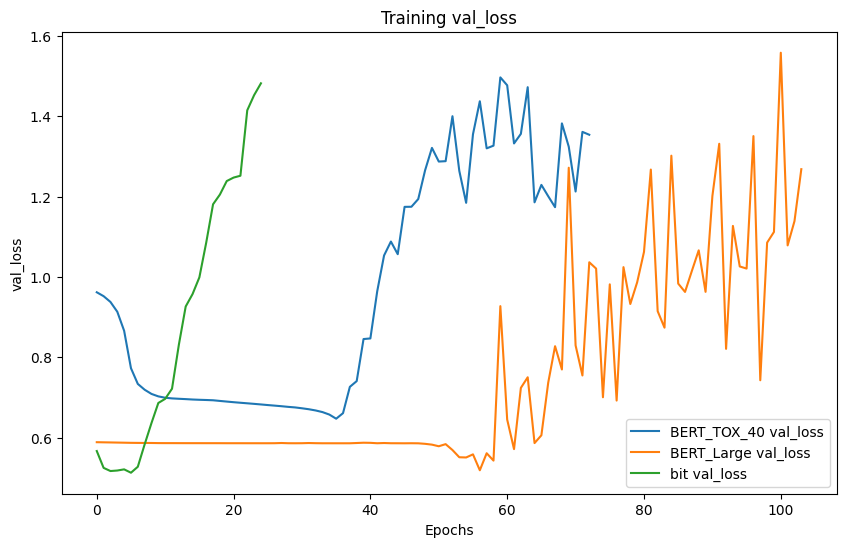

Tox :  herg


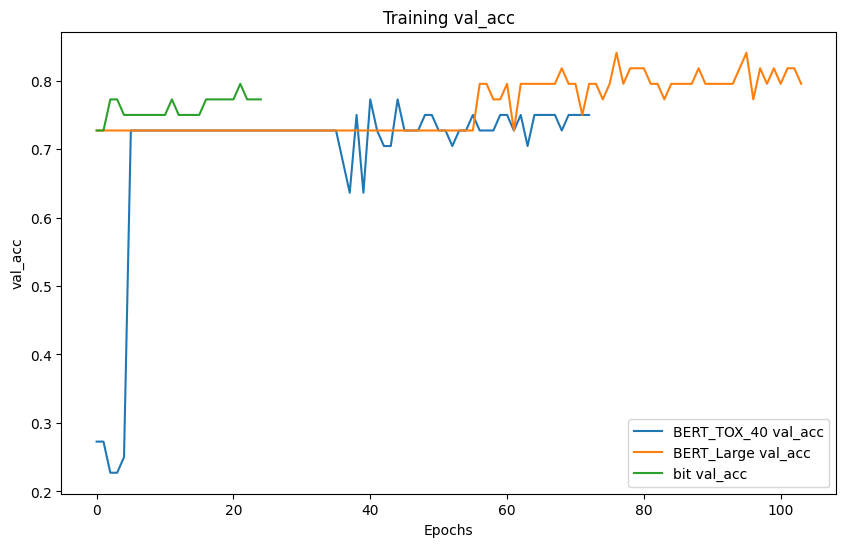

Tox :  herg


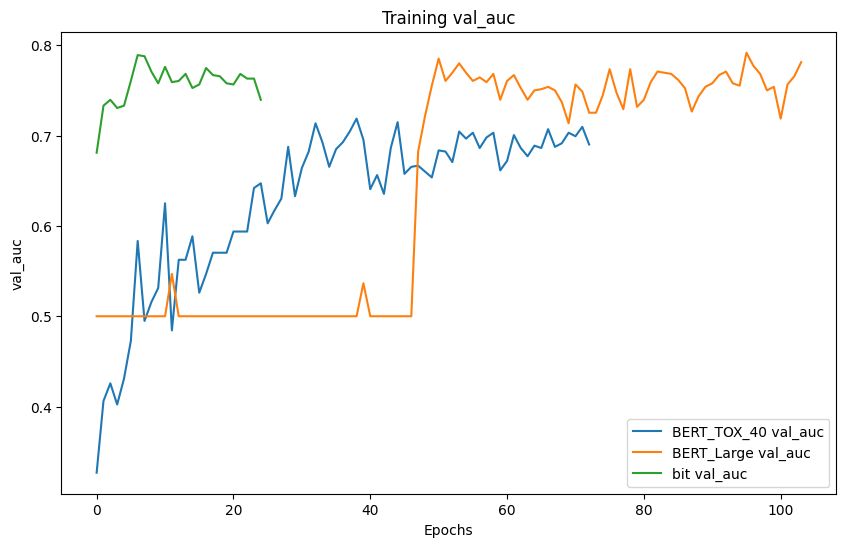

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2048)]            0         
                                                                 
 dense_32 (Dense)            (None, 250)               512250    
                                                                 
 dropout_15 (Dropout)        (None, 250)               0         
                                                                 
 dense_33 (Dense)            (None, 40)                10040     
                                                                 
 dropout_16 (Dropout)        (None, 40)                0         
                                                                 
 dense_34 (Dense)            (None, 10)                410       
                                                                 
 dropout_17 (Dropout)        (None, 10)                0   

Found local copy...
Loading...
Done!


Deleted sentences : 821
Sentences :  6557
['<unknown1>', '<start>', 'O=[N+]([O-])', 'c1cc', 'c2cc', 'c3ccc(', '[N+](=O)[O-])', 'c4', 'c5ccccc5', 'c1', 'c2c3', '4', '<end>']
Epoch 1/300
164/164 [==============================] - 27s 127ms/step - loss: 0.8198 - acc: 0.5550 - auc: 0.5159 - val_loss: 0.8035 - val_acc: 0.5587 - val_auc: 0.5921 - lr: 1.0000e-06
Epoch 2/300
164/164 [==============================] - 14s 88ms/step - loss: 0.8075 - acc: 0.5453 - auc: 0.5117 - val_loss: 0.7954 - val_acc: 0.5587 - val_auc: 0.5027 - lr: 2.0000e-06
Epoch 3/300
164/164 [==============================] - 13s 80ms/step - loss: 0.8048 - acc: 0.5396 - auc: 0.5017 - val_loss: 0.7915 - val_acc: 0.5587 - val_auc: 0.4944 - lr: 3.0000e-06
Epoch 4/300
164/164 [==============================] - 13s 79ms/step - loss: 0.7976 - acc: 0.5451 - auc: 0.5047 - val_loss: 0.7869 - val_acc: 0.5587 - val_auc: 0.5193 - lr: 4.0000e-06
Epoch 5/300
164/164 [==============================] - 13s 81ms/step - loss: 0.7934 - acc:

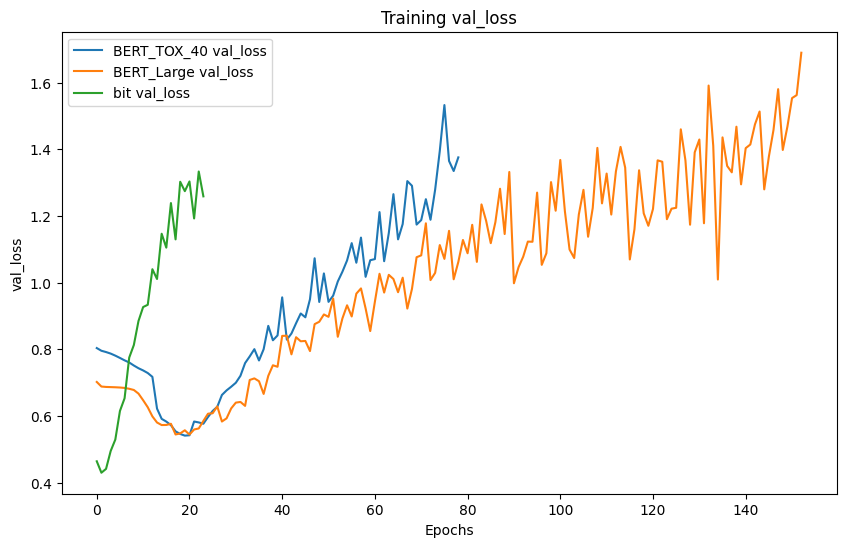

Tox :  AMES


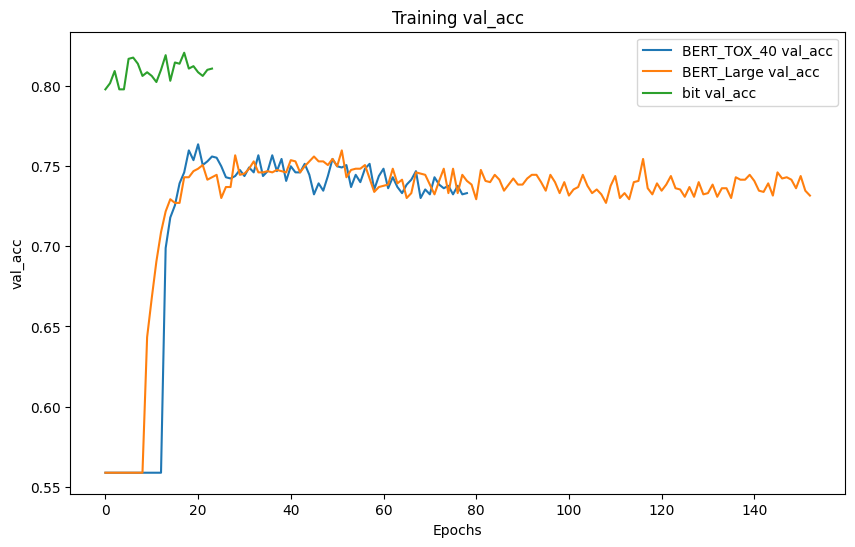

Tox :  AMES


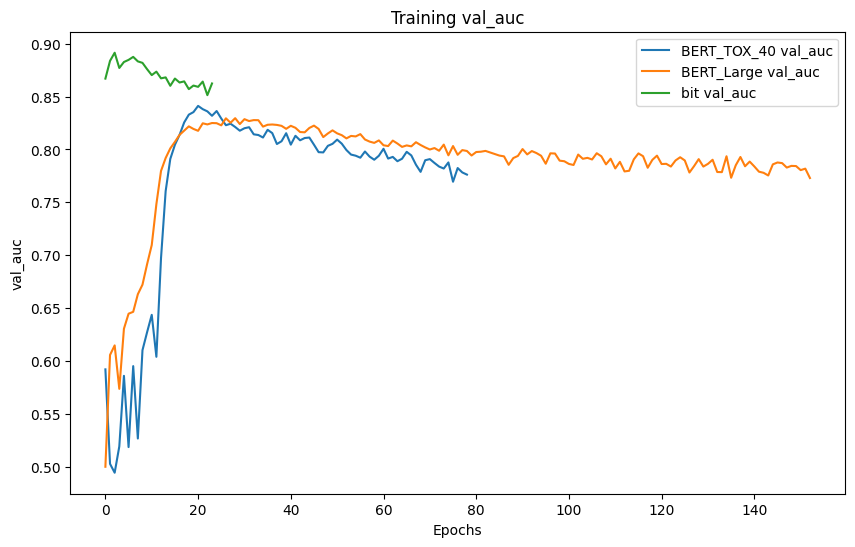

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2048)]            0         
                                                                 
 dense_56 (Dense)            (None, 250)               512250    
                                                                 
 dropout_26 (Dropout)        (None, 250)               0         
                                                                 
 dense_57 (Dense)            (None, 40)                10040     
                                                                 
 dropout_27 (Dropout)        (None, 40)                0         
                                                                 
 dense_58 (Dense)            (None, 10)                410       
                                                                 
 dropout_28 (Dropout)        (None, 10)                0  

Found local copy...
Loading...
Done!


Deleted sentences : 404
Sentences :  13060
['<unknown1>', '<start>', 'Fc1ccc(', '-n2', 'cc(N', 'CCN3', 'CCCCC3)', 'nn2)cc1', 'F', '<end>']
Epoch 1/300
327/327 [==============================] - 44s 115ms/step - loss: 0.8167 - acc: 0.5022 - auc: 0.5660 - val_loss: 0.8052 - val_acc: 0.4939 - val_auc: 0.4985 - lr: 1.0000e-06
Epoch 2/300
327/327 [==============================] - 28s 85ms/step - loss: 0.8082 - acc: 0.5031 - auc: 0.5010 - val_loss: 0.7977 - val_acc: 0.5038 - val_auc: 0.5051 - lr: 2.0000e-06
Epoch 3/300
327/327 [==============================] - 27s 84ms/step - loss: 0.7977 - acc: 0.5062 - auc: 0.5075 - val_loss: 0.7876 - val_acc: 0.5038 - val_auc: 0.5022 - lr: 3.0000e-06
Epoch 4/300
327/327 [==============================] - 28s 85ms/step - loss: 0.7868 - acc: 0.5033 - auc: 0.5018 - val_loss: 0.7757 - val_acc: 0.5038 - val_auc: 0.5002 - lr: 4.0000e-06
Epoch 5/300
327/327 [==============================] - 28s 84ms/step - loss: 0.7751 - acc: 0.5048 - auc: 0.5003 - val_loss: 

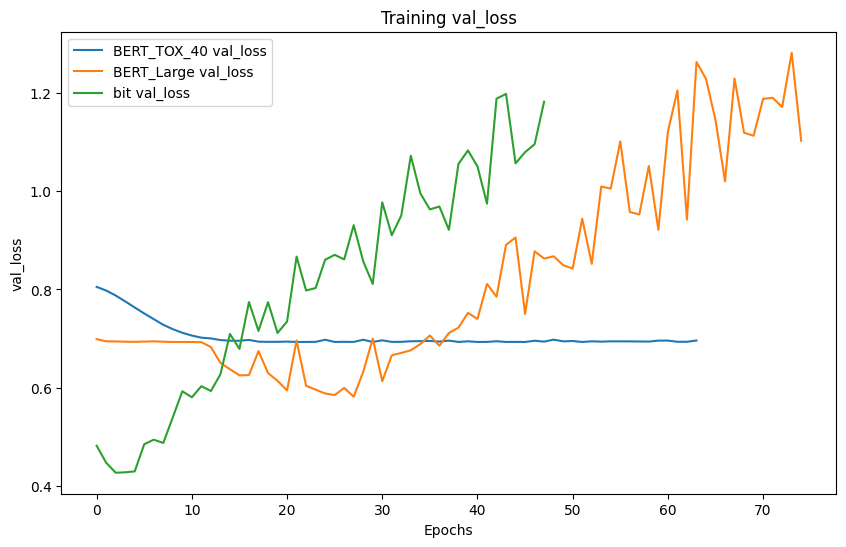

Tox :  herg_Karim


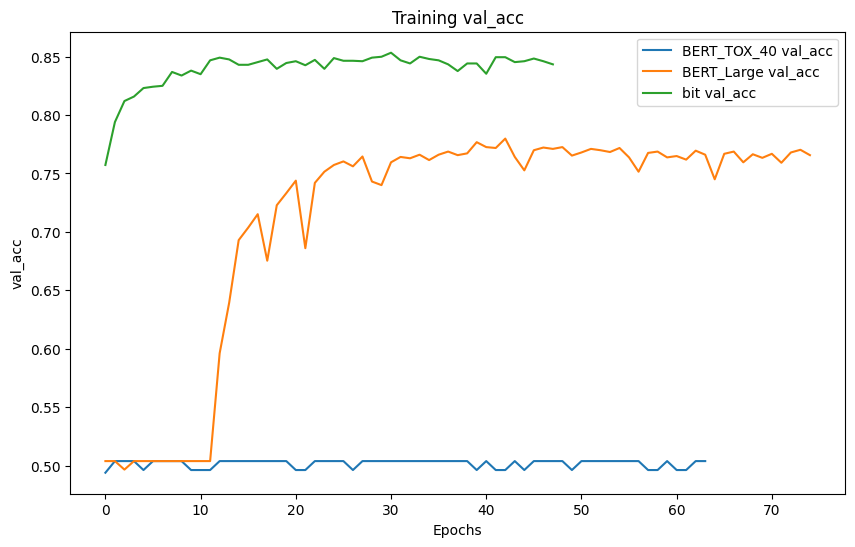

Tox :  herg_Karim


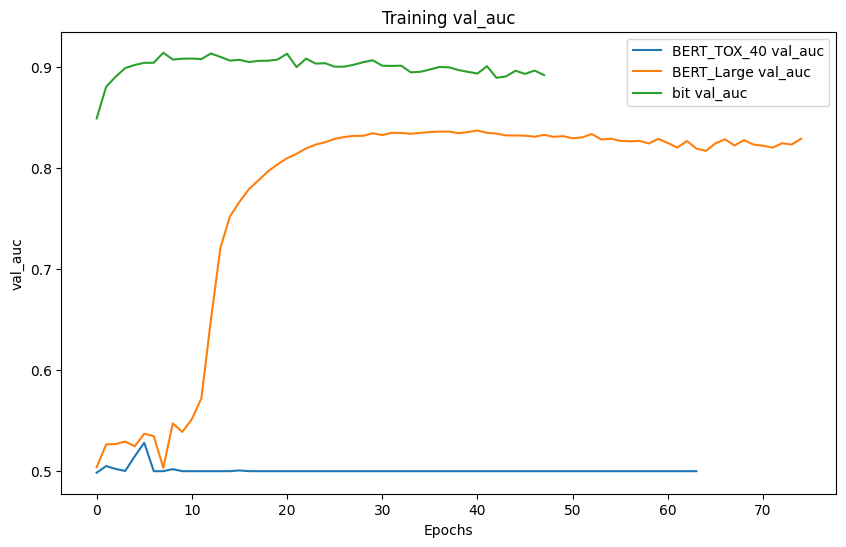

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2048)]            0         
                                                                 
 dense_80 (Dense)            (None, 250)               512250    
                                                                 
 dropout_37 (Dropout)        (None, 250)               0         
                                                                 
 dense_81 (Dense)            (None, 40)                10040     
                                                                 
 dropout_38 (Dropout)        (None, 40)                0         
                                                                 
 dense_82 (Dense)            (None, 10)                410       
                                                                 
 dropout_39 (Dropout)        (None, 10)                0  

Found local copy...
Loading...
Done!


Deleted sentences : 806
Sentences :  103
['<unknown1>', '<start>', 'C', '[N+](C)(C)', 'CC(=O)', '[O-]', '<end>']
Epoch 1/300
3/3 [==============================] - 8s 750ms/step - loss: 0.6491 - acc: 0.7927 - auc: 0.8902 - val_loss: 0.6664 - val_acc: 0.7619 - val_auc: 0.5000 - lr: 1.0000e-06
Epoch 2/300
3/3 [==============================] - 1s 202ms/step - loss: 0.6365 - acc: 0.7927 - auc: 0.5724 - val_loss: 0.6663 - val_acc: 0.7619 - val_auc: 0.5000 - lr: 2.0000e-06
Epoch 3/300
3/3 [==============================] - 0s 178ms/step - loss: 0.6358 - acc: 0.7927 - auc: 0.5729 - val_loss: 0.6662 - val_acc: 0.7619 - val_auc: 0.3625 - lr: 3.0000e-06
Epoch 4/300
3/3 [==============================] - 1s 221ms/step - loss: 0.6334 - acc: 0.7927 - auc: 0.5190 - val_loss: 0.6663 - val_acc: 0.7619 - val_auc: 0.2562 - lr: 4.0000e-06
Epoch 5/300
3/3 [==============================] - 1s 206ms/step - loss: 0.6472 - acc: 0.7927 - auc: 0.4774 - val_loss: 0.6660 - val_acc: 0.7619 - val_auc: 0.3000 - lr

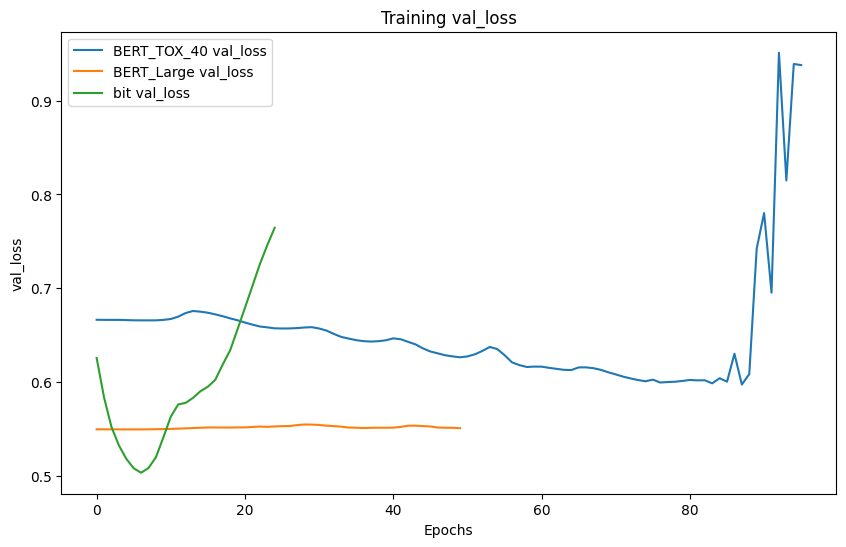

Tox :  DILI


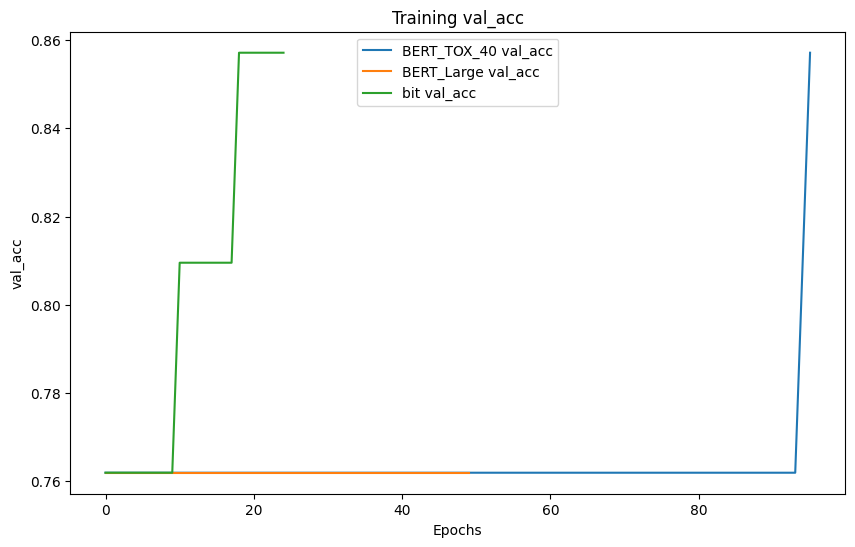

Tox :  DILI


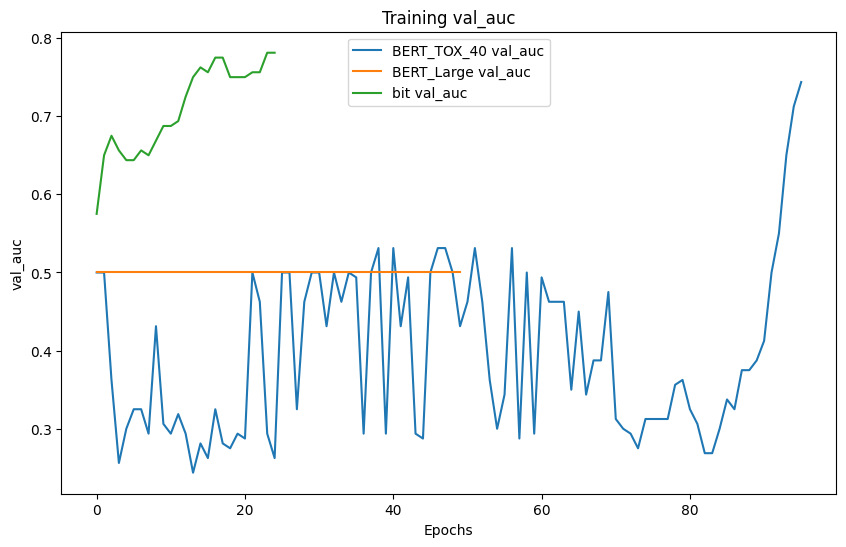

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2048)]            0         
                                                                 
 dense_104 (Dense)           (None, 250)               512250    
                                                                 
 dropout_48 (Dropout)        (None, 250)               0         
                                                                 
 dense_105 (Dense)           (None, 40)                10040     
                                                                 
 dropout_49 (Dropout)        (None, 40)                0         
                                                                 
 dense_106 (Dense)           (None, 10)                410       
                                                                 
 dropout_50 (Dropout)        (None, 10)                0  

Found local copy...
Loading...
Done!


Deleted sentences : 498
Sentences :  169
['<unknown1>', '<start>', 'CC', '=C(C)', 'C', '=O', '<end>']
Epoch 1/300
5/5 [==============================] - 8s 390ms/step - loss: 0.6942 - acc: 0.7111 - auc: 0.6784 - val_loss: 0.6990 - val_acc: 0.7353 - val_auc: 0.5911 - lr: 1.0000e-06
Epoch 2/300
5/5 [==============================] - 1s 186ms/step - loss: 0.6819 - acc: 0.7407 - auc: 0.5025 - val_loss: 0.6979 - val_acc: 0.7353 - val_auc: 0.4089 - lr: 2.0000e-06
Epoch 3/300
5/5 [==============================] - 1s 170ms/step - loss: 0.6672 - acc: 0.7778 - auc: 0.5137 - val_loss: 0.6968 - val_acc: 0.7353 - val_auc: 0.5000 - lr: 3.0000e-06
Epoch 4/300
5/5 [==============================] - 1s 190ms/step - loss: 0.6921 - acc: 0.7407 - auc: 0.4683 - val_loss: 0.6953 - val_acc: 0.7353 - val_auc: 0.5911 - lr: 4.0000e-06
Epoch 5/300
5/5 [==============================] - 1s 164ms/step - loss: 0.6865 - acc: 0.7259 - auc: 0.4665 - val_loss: 0.6938 - val_acc: 0.7353 - val_auc: 0.5000 - lr: 5.0000e-0

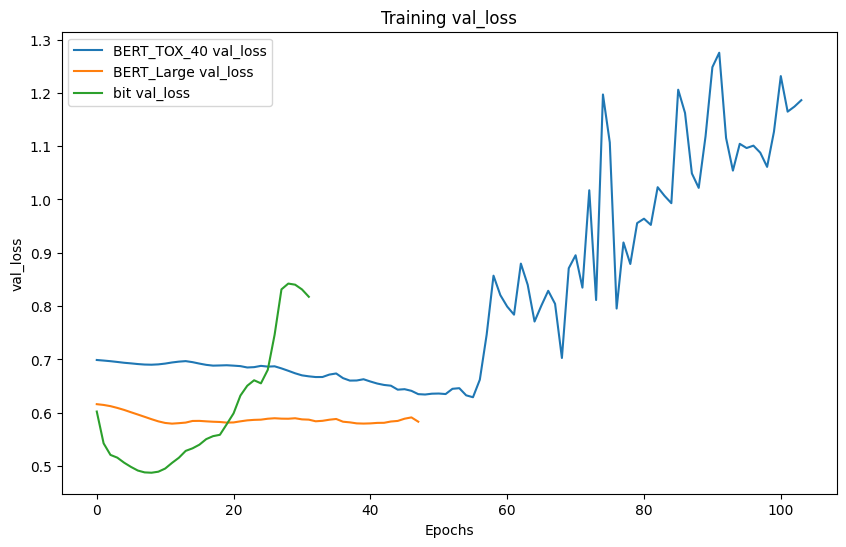

Tox :  Skin Reaction


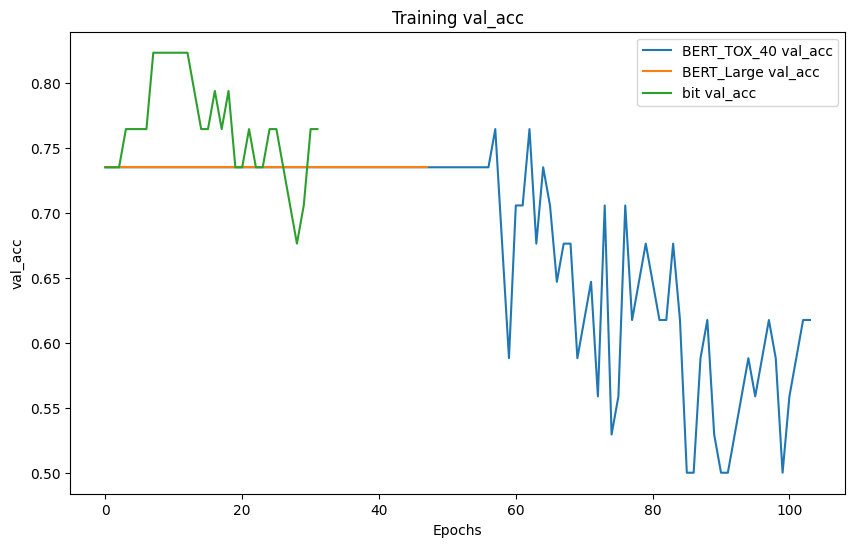

Tox :  Skin Reaction


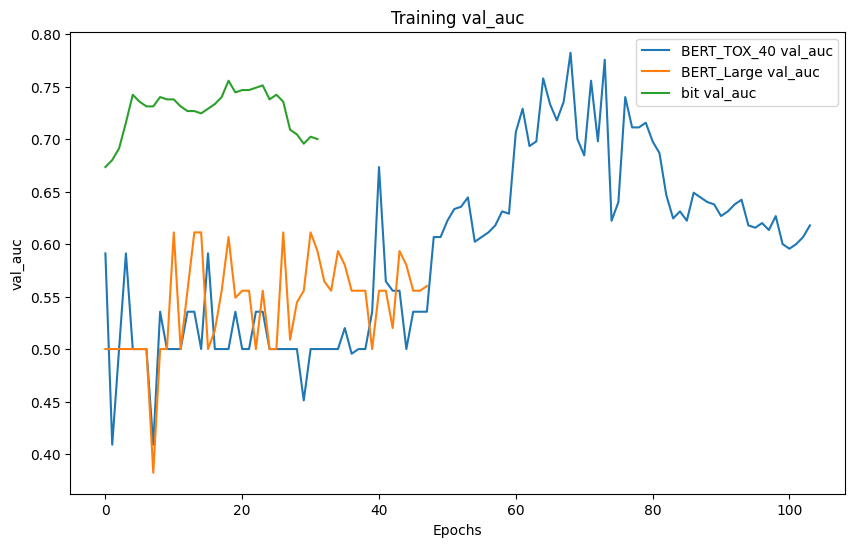

In [7]:
from Models.BERT import BERT_train
from Module.classification_SPE import ModelPlotter
from tensorflow.keras.metrics import AUC
tox = ['herg','AMES','herg_Karim','DILI','Skin Reaction']
auc = AUC()

for t in tox:
    import tensorflow as tf
    from tensorflow.keras.layers import MaxPool2D
    from tensorflow.keras.layers import Conv2D
    from tensorflow.keras.layers import Input
    from tensorflow.keras.layers import Flatten,Dense
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Dropout
    inputs = Input(shape=(2048,),name='input')
    outputs = Dense(250,activation = 'relu')(inputs)
    outputs = Dropout(0.3)(outputs)
    outputs = Dense(40,activation = 'relu')(outputs)
    outputs = Dropout(0.3)(outputs)
    outputs = Dense(10,activation = 'relu')(outputs)
    outputs = Dropout(0.3)(outputs)
    outputs = Dense(1,activation = 'sigmoid')(outputs)

    model_NN = Model(inputs= [inputs], outputs=[outputs])
    model_NN.summary()
    model_NN.compile(optimizer='Adam',loss = 'binary_crossentropy',metrics=['acc',auc])



    BERT_model = BERT_train("./BERT/SmiletoPE/Fine_tunned/ALL_TOX.h5",3500)
    BERT_model.compile(optimizer='Adam',loss = 'binary_crossentropy',metrics=['acc',auc])
    BERT_model1 = BERT_train("./BERT/SmiletoPE/L_model_weights.h5",3500)
    BERT_model1.compile(optimizer='Adam',loss = 'binary_crossentropy',metrics=['acc',auc])
    
    
    models = {'BERT_TOX_40':BERT_model,'BERT_Large':BERT_model1,'bit':model_NN}
    train,tox_info= Tox(name = t).get_data(format = 'DeepPurpose')
    
    Model_analyze = ModelPlotter(models,train,tox_info,[callback,reduce_lr,custom_callback],config = {'Tox':'ALL_TOX'})
    Model_analyze.model_fitting()

    test_list = ['loss','acc','val_acc','val_auc_1']
    for test in BERT_model.history.history.keys():
        try:
            if test[:3] == 'val':
                print('Tox : ',t)
                Model_analyze.plot_training_history([test])
                plt.show()
        except:
            continue